#### Importing neccessary libraries

1. **Numpy** for *linear algebra*
2. **Pandas** for reading csv files and DataFrame handling
3. **Tensorflow** for *machine learning*
4. **Keras** for defining the *LSTM model architecture* and regularization
5. Functions such as **train_test_split** for dividing the dataset into training and test set and **GridSearchCV** to tune hyperparameters across a grid of values.
6. **MinMaxScaler** to scale the variable values to a range of $[0,1]$.  
7. **matplotlib** for plotting results
8. **logging** for errors.

In [1]:
pip install scikeras

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 30.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 86.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 311.2/311.2 kB 43.3 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.2.2
    Uninstalling scikit-learn-1.2.2:
      Successfully uninstalled scikit-learn-1.2.2
  Attempting uninstall: keras
    Found existing installation: keras 2.15.0
    Uninstalling keras-2.15.0:
      Successfully uninstalled keras-2.15.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.15.0 requires keras<2.16,>=2.15.0, but you have keras 3.3.3 which is incompatible.


In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, Input
from sklearn.model_selection import train_test_split, GridSearchCV
from keras.callbacks import EarlyStopping
from keras.utils import to_categorical
from sklearn.preprocessing import MinMaxScaler
from scikeras.wrappers import KerasClassifier
from itertools import product
import matplotlib.pyplot as plt
from keras.regularizers import l2
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from keras.callbacks import EarlyStopping

## Setting Device to GPU

Since the model is run in Google Colab with an external GPU for increased computational ability the device which is used needs to be defined:

In [ ]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
    logging.warning('GPU device not found. Use CPU instead')
else:
    logging.info(f'Found GPU at: {device_name}')

# Data Loading

In [ ]:
file_path = '/content/final_dataset.csv'
df = pd.read_csv(file_path)

dataset = df.values[:, 0:].astype('float64')

diff = dataset[:,0:1]

In [ ]:
np.random.seed(42)
tf.random.set_seed(42)

# Output Variable Transformation and Data Scaling

In [ ]:
# 34.1 quantile: -0.0021999999999999
# 65 quantile:  0.0021999999999999

def categorize_diff(diff):
    if diff < -0.0021999999999999:
        return 0  # Price fall bucket
    elif diff > 0.0021999999999999:
        return 2  # Price rise bucket
    else:
        return 1  # No action bucket

y_categories = np.array([categorize_diff(pc) for pc in diff])

In [ ]:
y_categories = to_categorical(y_categories)

scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset[:, 1:])

# Conversion to Tensor

In [ ]:
def create_dataset(dataset, time_steps = 1):
    dataX = []
    for i in range(len(dataset) - time_steps):
        a = dataset[i:(i + time_steps), :]
        dataX.append(a)
    return np.array(dataX)

# 1st Iteration

* time steps = 10,
* epochs = 100,
* 1 hidden layer,
* 0.3 dropout rate,
* 32 batch size,

In [ ]:
time_steps = 15

dataX = create_dataset(dataset, time_steps)

dataX = np.reshape(dataX, (dataX.shape[0], time_steps, dataset.shape[1]))

X = dataX
y = y_categories[time_steps:]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False, random_state = 42)

In [ ]:
def create_model(units1=128, dropout_rate1 = 0.1, batch_size = 32):
    model = Sequential([
        Input(shape=(X_train.shape[1], X_train.shape[2])),
        LSTM(units1, return_sequences = False),
        Dropout(dropout_rate1),
        Dense(3, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [ ]:
model = KerasClassifier(model = create_model, epochs = 75, verbose = 0, shuffle = False, random_state = 42)

In [ ]:
param_grid = {
    'model__units1': [32, 64, 128],
    'model__dropout_rate1': [0.1, 0.2, 0.3, 0.4],
    'batch_size': [128, 64, 32]
}

In [ ]:
grid = GridSearchCV(estimator=model, param_grid=param_grid, cv = 5, n_jobs = -1)

In [ ]:
early_stopping = EarlyStopping(monitor = 'val_loss', patience = 5, start_from_epoch = 10, restore_best_weights = True)

grid_result = grid.fit(X_train, y_train, callbacks = [early_stopping], validation_split = 0.2)

/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()


In [ ]:
best_params = grid_result.best_params_
logging.info(f"Best Parameters: {best_params}")
print(best_params)

{'batch_size': 128, 'model__dropout_rate1': 0.1, 'model__units1': 32}


{'batch_size': 128, 'model__dropout_rate1': 0.1, 'model__units1': 32}

In [ ]:
best_model = create_model(batch_size = best_params['batch_size'],
                          dropout_rate1 = best_params['model__dropout_rate1'],
                          units1 = best_params['model__units1'],
                          )

In [ ]:
early_stopping_manual = EarlyStopping(monitor='val_loss', patience = 10, restore_best_weights = True)
history = best_model.fit(X_train, y_train,
                         epochs = 75,
                         batch_size = 128,
                         validation_data = (X_test, y_test),
                         shuffle = False,
                         callbacks = [early_stopping_manual],
                         verbose = 0
                         )

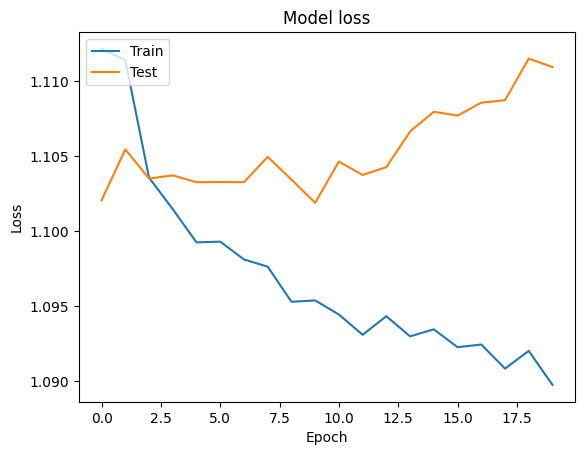

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


<Figure size 1000x700 with 0 Axes>

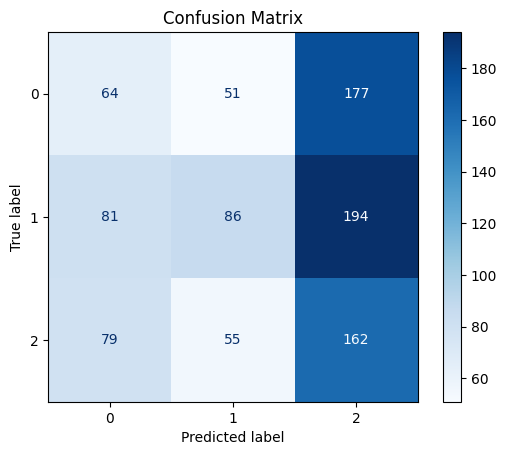

In [ ]:
y_pred = best_model.predict(X_test)

actual_categories = np.argmax(y_test, axis=1)

predicted_categories = np.argmax(y_pred, axis=1)

cm = confusion_matrix(actual_categories, predicted_categories)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1, 2])

plt.figure(figsize=(10, 7))
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

In [32]:
file_path = '/content/usd_eur_raw.csv'
df_raw_exchange = pd.read_csv(file_path)

df_raw_exchange = df_raw_exchange['usd_eur_exchange'].pct_change()

df_raw_exchange = df_raw_exchange.iloc[3:-1]

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import accuracy_score

def compute_hit_rate(signals, percent_changes):
    correct_signals = 0
    total_signals = len(signals)

    for signal, percent_change in zip(signals, percent_changes):
        if (signal == 0 and percent_change < 0) or (signal == 2 and percent_change > 0):
            correct_signals += 1
        elif signal == 1:
            total_signals -= 1

    return correct_signals / total_signals if total_signals > 0 else 0

def backtest(actions, percent_changes):
    cash = 100
    position = 0  # Current position: 0 for flat, -1 for short, 1 for long
    portfolio_value = []

    for action, percent_change in zip(actions, percent_changes):
        if action == 0:  # Sell
            position = -100  # Set position to short
            cash += position * percent_change  # Sell shares
        elif action == 1:  # Flat
            position = 0  # Set position to flat
            cash += 0  # No action
        elif action == 2:  # Buy
            position = 100  # Set position to long
            cash += position * percent_change  # Buy shares

        portfolio_value.append(cash)  # Calculate portfolio value

    return portfolio_value

def run_single_iteration(X_train, y_train, X_test, y_test, best_params):
    best_model = create_model(batch_size = best_params['batch_size'],
                              dropout_rate1 = best_params['model__dropout_rate1'],
                              units1 = best_params['model__units1']
    )

    early_stopping_manual = EarlyStopping(monitor='val_loss', patience = 10, restore_best_weights = True)
    history = best_model.fit(X_train, y_train,
                             epochs=75,
                             validation_data=(X_test, y_test),
                             batch_size = 128,
                             shuffle=False,
                             callbacks=[early_stopping_manual],
                             verbose=0)

    predictions = best_model.predict(X_test)
    predicted_categories = np.argmax(predictions, axis=1)

    y_test_labels = np.argmax(y_test, axis=1)

    accuracy = accuracy_score(y_test_labels, predicted_categories)

    signals = predicted_categories
    percent_changes = np.array(df_raw_exchange.iloc[-len(y_test):])

    portfolio_value = backtest(signals, percent_changes)
    hit_rate = compute_hit_rate(signals, percent_changes)
    num_trades = np.sum((signals == 0) | (signals == 2))


    return portfolio_value, accuracy, hit_rate, num_trades

iterations = 50

final_portfolio_values = []
accuracies = []
hit_rates = []
trade_counts = []

for i in range(iterations):
    print(f"Running iteration {i+1}/{iterations}")
    portfolio_value, accuracy, hit_rate, num_trades = run_single_iteration(X_train, y_train, X_test, y_test, best_params)
    final_portfolio_values.append(portfolio_value[-1])
    accuracies.append(accuracy)
    hit_rates.append(hit_rate)
    trade_counts.append(num_trades)
    print(f"Iteration {i+1} - Final Portfolio Value: {portfolio_value[-1]}, Accuracy: {accuracy}, Hit Rate: {hit_rate}, Trades: {num_trades}")

average_final_value = np.mean(final_portfolio_values)
std_final_value = np.std(final_portfolio_values)

average_accuracy = np.mean(accuracies)
average_hit_rate = np.mean(hit_rates)
average_num_trades = np.mean(trade_counts)

print("Average Final Portfolio Value:")
print(average_final_value)
print('Standard Deviation of Final Values:')
print(std_final_value)
print('Average Accuracy:')
print(average_accuracy)
print('Average Hit Rate:')
print(average_hit_rate)
print('Average No. of Trades:')
print(average_num_trades)

Running iteration 1/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
Iteration 1 - Final Portfolio Value: 130.9705919301891, Accuracy: 0.339304531085353, Hit Rate: 0.540084388185654, Trades: 948
Running iteration 2/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
Iteration 2 - Final Portfolio Value: 125.08088819532354, Accuracy: 0.37302423603793466, Hit Rate: 0.5284974093264249, Trades: 579
Running iteration 3/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step
Iteration 3 - Final Portfolio Value: 88.20719257530371, Accuracy: 0.3424657534246575, Hit Rate: 0.4577922077922078, Trades: 308
Running iteration 4/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step
Iteration 4 - Final Portfolio Value: 92.43205228245992, Accuracy: 0.38461538461538464, Hit Rate: 0.4423076923076923, Trades: 52
Running iteration 5/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step
Iteration 5 - Final Portfolio Value: 109.52243784995402, Accuracy: 0.35089567966280294, Hit Rate: 0.5020833333333333, Trades: 480
Running iteration 6/50
30/30 ━━━━━━━━━━━━━━━━

# 2nd Iteration


In [ ]:
from tensorflow.keras.regularizers import l2

In [ ]:
time_steps = 15

dataX = create_dataset(dataset, time_steps)

dataX = np.reshape(dataX, (dataX.shape[0], time_steps, dataset.shape[1]))

X = dataX
y = y_categories[time_steps:]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

In [ ]:
def create_model_3(units1=128, dropout_rate1 = 0.3, batch_size = 32, l2_value = 0.01):
    model = Sequential([
        Input(shape=(X_train.shape[1], X_train.shape[2])),
        LSTM(units1, return_sequences = True),
        Dropout(dropout_rate1),
        Dense(3, activation='softmax', kernel_regularizer = l2(l2_value))
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [ ]:
model_3 = KerasClassifier(model = create_model_3, epochs = 75, verbose = 0, shuffle = False, random_state = 42)

In [ ]:
param_grid_model3 = {
    'model__units1': [32, 64, 128],
    'model__dropout_rate1': [0.4, 0.3, 0.2],
    'batch_size': [32, 64, 128],
    'model__l2_value': [0.1, 0.01, 0.001]
}

In [ ]:
logging.info('Starting grid search')
grid_model_3 = GridSearchCV(estimator = model_3, param_grid = param_grid_model3, cv = 5, n_jobs = -1)

In [ ]:
from keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor = 'val_loss', patience = 5, start_from_epoch = 10, restore_best_weights = True)

# Fit the grid search
grid_result_model_3 = grid_model_3.fit(X_train, y_train, validation_split = 0.2, callbacks = [early_stopping])

/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()
/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


In [ ]:
best_params_model_3 = grid_result_model_3.best_params_
logging.info(f"Best Parameters: {best_params_model_3}")
print(best_params_model_3)

{'batch_size': 128, 'model__dropout_rate1': 0.4, 'model__l2_value': 0.1, 'model__units1': 128}


In [ ]:
best_model_3 = create_model_3(units1 = best_params_model_3['model__units1'],
                          dropout_rate1 = best_params_model_3['model__dropout_rate1'],
                          batch_size = best_params_model_3['batch_size'],
                          l2_value = best_params_model_3['model__l2_value'],
                          )

In [ ]:
early_stopping_manual = EarlyStopping(monitor='val_loss', patience = 10, restore_best_weights = True)

history_model_3 = best_model_3.fit(X_train, y_train,
                         epochs=100,
                         validation_data=(X_test, y_test),
                                   batch_size = 128,
                        callbacks = [early_stopping_manual],
                         verbose=0)

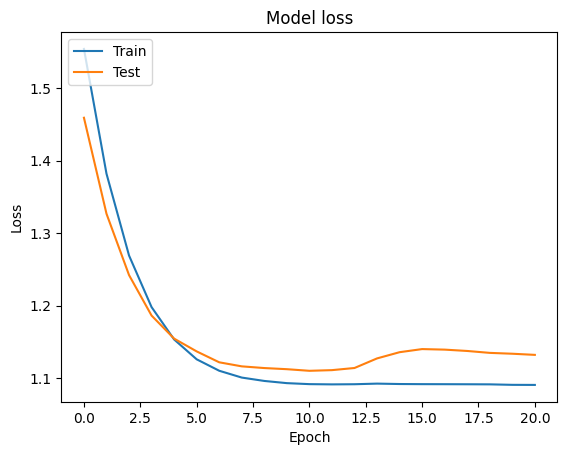

In [ ]:
# Plot training & validation loss values
plt.plot(history_model_3.history['loss'])
plt.plot(history_model_3.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step


<Figure size 1000x700 with 0 Axes>

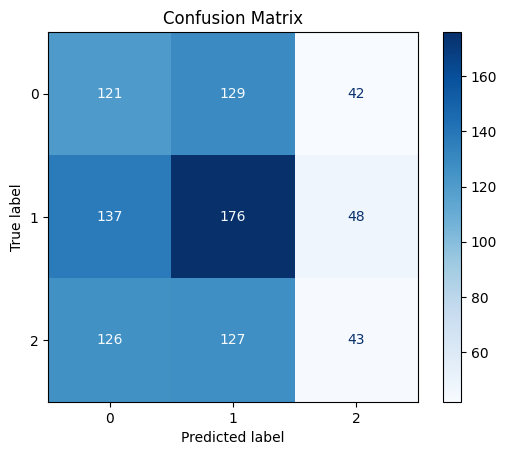

In [ ]:
# Assuming `grid_result` is the result from GridSearchCV and contains the best model

# Predict on the test set
y_pred = best_model_3.predict(X_test)

# Convert the one-hot encoded actual labels back to integer format
actual_categories = np.argmax(y_test, axis=1)

# Get the predicted categories
predicted_categories = np.argmax(y_pred, axis=1)

# Compute the confusion matrix
cm = confusion_matrix(actual_categories, predicted_categories)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1, 2])

# Plot the confusion matrix
plt.figure(figsize=(10, 7))
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import accuracy_score

# Assuming the functions to create and compile your model are defined as `create_model`

def compute_hit_rate(signals, percent_changes):
    correct_signals = 0
    total_signals = len(signals)

    for signal, percent_change in zip(signals, percent_changes):
        if (signal == 0 and percent_change < 0) or (signal == 2 and percent_change > 0):
            correct_signals += 1
        elif signal == 1:
            total_signals -= 1

    return correct_signals / total_signals if total_signals > 0 else 0

def backtest(actions, percent_changes):
    cash = 100  # Initial cash
    position = 0  # Current position: 0 for flat, -1 for short, 1 for long
    portfolio_value = []  # Portfolio value over time

    for action, percent_change in zip(actions, percent_changes):
        if action == 0:  # Sell
            position = -100  # Set position to short
            cash += position * percent_change  # Sell shares
        elif action == 1:  # Flat
            position = 0  # Set position to flat
            cash += 0  # No action
        elif action == 2:  # Buy
            position = 100  # Set position to long
            cash += position * percent_change  # Buy shares

        portfolio_value.append(cash)  # Calculate portfolio value

    return portfolio_value

def run_single_iteration(X_train, y_train, X_test, y_test, best_params):
    # Create the model with the best parameters
    best_model_3 = create_model_3(units1 = best_params_model_3['model__units1'],
                          dropout_rate1 = best_params_model_3['model__dropout_rate1'],
                          batch_size = best_params_model_3['batch_size'],
                          l2_value = best_params_model_3['model__l2_value']
                          )

    early_stopping_manual = EarlyStopping(monitor='val_loss', patience = 10, restore_best_weights = True)

    history_model_3 = best_model_3.fit(X_train, y_train,
                         epochs=100,
                         validation_data=(X_test, y_test),
                                   batch_size = 128,
                        callbacks = [early_stopping_manual],
                         verbose=0)

    # Predict on the test set
    predictions = best_model_3.predict(X_test)
    predicted_categories = np.argmax(predictions, axis=1)

    # Convert y_test from one-hot encoding to label format
    y_test_labels = np.argmax(y_test, axis=1)

    # Calculate accuracy
    accuracy = accuracy_score(y_test_labels, predicted_categories)

    # Generate signals based on predicted categories
    signals = predicted_categories
    percent_changes = np.array(df_raw_exchange.iloc[-len(y_test):])

    # Run the backtest
    portfolio_value = backtest(signals, percent_changes)
    hit_rate = compute_hit_rate(signals, percent_changes)
    num_trades = np.sum((signals == 0) | (signals == 2))


    return portfolio_value, accuracy, hit_rate, num_trades

# Number of iterations for averaging
iterations = 50

# Lists to store the results of each iteration
final_portfolio_values = []
accuracies = []
hit_rates = []
trade_counts = []

for i in range(iterations):
    print(f"Running iteration {i+1}/{iterations}")
    portfolio_value, accuracy, hit_rate, num_trades = run_single_iteration(X_train, y_train, X_test, y_test, best_params_model_3)
    final_portfolio_values.append(portfolio_value[-1])
    accuracies.append(accuracy)
    hit_rates.append(hit_rate)
    trade_counts.append(num_trades)
    print(f"Iteration {i+1} - Final Portfolio Value: {portfolio_value[-1]}, Accuracy: {accuracy}, Hit Rate: {hit_rate}, Trades: {num_trades}")

# Calculate the average and standard deviation of the final portfolio values
average_final_value = np.mean(final_portfolio_values)
std_final_value = np.std(final_portfolio_values)

# Calculate the average accuracy and hit rate
average_accuracy = np.mean(accuracies)
average_hit_rate = np.mean(hit_rates)
average_num_trades = np.mean(trade_counts)

# Print results
print("Average Final Portfolio Value:")
print(average_final_value)
print('Standard Deviation of Final Values:')
print(std_final_value)
print('Average Accuracy:')
print(average_accuracy)
print('Average Hit Rate:')
print(average_hit_rate)
print('Average No. of Trades:')
print(average_num_trades)

Running iteration 1/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step
Iteration 1 - Final Portfolio Value: 92.99336673141849, Accuracy: 0.34562697576396206, Hit Rate: 0.4956521739130435, Trades: 690
Running iteration 2/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step
Iteration 2 - Final Portfolio Value: 97.36188788517133, Accuracy: 0.3582718651211802, Hit Rate: 0.49538461538461537, Trades: 650
Running iteration 3/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step
Iteration 3 - Final Portfolio Value: 106.47416323425908, Accuracy: 0.3698630136986301, Hit Rate: 0.5081168831168831, Trades: 616
Running iteration 4/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step
Iteration 4 - Final Portfolio Value: 98.08279287007241, Accuracy: 0.35511064278187565, Hit Rate: 0.5073529411764706, Trades: 680
Running iteration 5/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step
Iteration 5 - Final Portfolio Value: 89.27737583290553, Accuracy: 0.3224446786090622, Hit Rate: 0.4894459102902375, Trades: 758
Running iteration 6/50
30/30 ━━━━━━━━━━━━

# 3rd Iteration

2-layer LSTM with Regularization


In [ ]:
time_steps = 15

dataX = create_dataset(dataset, time_steps)

dataX = np.reshape(dataX, (dataX.shape[0], time_steps, dataset.shape[1]))

X = dataX
y = y_categories[time_steps:]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False, random_state = 42)

In [ ]:
def create_model_3(units1 = 128, units2 = 64,  dropout_rate1 = 0.2, dropout_rate2 = 0.1, batch_size = 32, l2_value = 0.01):
    model = Sequential([
        Input(shape=(X_train.shape[1], X_train.shape[2])),
        LSTM(units1, return_sequences = True),
        Dropout(dropout_rate1),
        LSTM(units2, return_sequences = False),
        Dropout(dropout_rate2),
        Dense(3, activation = 'softmax', kernel_regularizer=l2(l2_value))
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [ ]:
param_grid_model_3 = {
    'model__units1': [64, 128],
    'model__units2': [64, 128],
    'model__dropout_rate1': [0.2, 0.3, 0.4],
    'model__dropout_rate2': [0.2, 0.3, 0.4],
    'batch_size': [64, 128],
    'model__l2_value': [0.1, 0.01]
}

In [ ]:
model_3 = KerasClassifier(model = create_model_3, epochs = 75, verbose = 0, shuffle = False, random_state = 42)

In [ ]:
# Perform Grid Search with 5-fold cross-validation
logging.info('Starting grid search...')
grid_model_3 = GridSearchCV(estimator=model_3, param_grid=param_grid_model_3, cv=5, scoring = 'accuracy', n_jobs = -1)

In [ ]:
from keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor = 'val_loss', patience = 5, start_from_epoch = 10, restore_best_weights = True)

# Fit the grid search
grid_result_model_3 = grid_model_3.fit(X_train, y_train, validation_split = 0.2, callbacks = [early_stopping])

/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()
/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


In [ ]:
best_params_model_3 = grid_result_model_3.best_params_
logging.info(f"Best Parameters: {best_params_model_3}")
print(best_params_model_3)

{'batch_size': 128, 'model__dropout_rate1': 0.4, 'model__dropout_rate2': 0.3, 'model__l2_value': 0.1, 'model__units1': 128, 'model__units2': 64}


In [ ]:
best_model_3 = create_model_4(units1 = best_params_model_3['model__units1'],
                              units2 = best_params_model_3['model__units2'],
                          dropout_rate1 = best_params_model_3['model__dropout_rate1'],
                              dropout_rate2 = best_params_model_3['model__dropout_rate2'],
                          batch_size = best_params_model_3['batch_size'],
                              l2_value = best_params_model_3['model__l2_value']
                          )

In [ ]:
early_stopping = EarlyStopping(monitor = 'val_loss', patience = 5, start_from_epoch = 10, restore_best_weights = True)

history_model_3 = best_model_3.fit(X_train, y_train,
                         epochs=75,
                                   batch_size = 128,
                         validation_data=(X_test, y_test),
                                   callbacks = [early_stopping],
                         verbose=0)

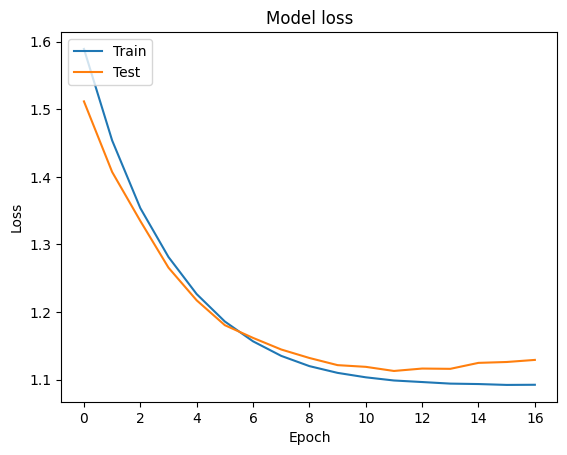

In [ ]:
# Plot training & validation loss values
plt.plot(history_model_3.history['loss'])
plt.plot(history_model_3.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


<Figure size 1000x700 with 0 Axes>

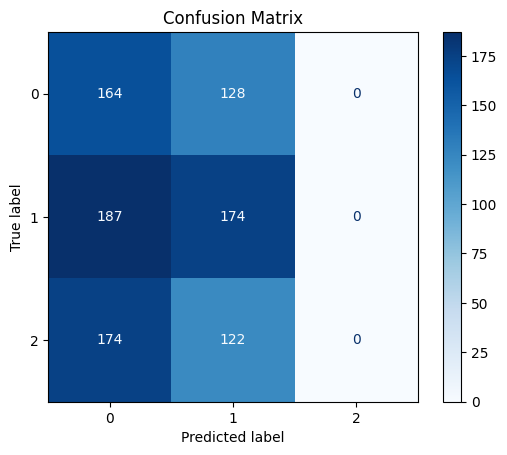

In [ ]:
# Assuming `grid_result` is the result from GridSearchCV and contains the best model

# Predict on the test set
y_pred = best_model_3.predict(X_test)

# Convert the one-hot encoded actual labels back to integer format
actual_categories = np.argmax(y_test, axis=1)

# Get the predicted categories
predicted_categories = np.argmax(y_pred, axis=1)

# Compute the confusion matrix
cm = confusion_matrix(actual_categories, predicted_categories)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1, 2])

# Plot the confusion matrix
plt.figure(figsize=(10, 7))
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import accuracy_score

# Assuming the functions to create and compile your model are defined as `create_model`

def compute_hit_rate(signals, percent_changes):
    correct_signals = 0
    total_signals = len(signals)

    for signal, percent_change in zip(signals, percent_changes):
        if (signal == 0 and percent_change < 0) or (signal == 2 and percent_change > 0):
            correct_signals += 1
        elif signal == 1:
            total_signals -= 1

    return correct_signals / total_signals if total_signals > 0 else 0

def backtest(actions, percent_changes):
    cash = 100  # Initial cash
    position = 0  # Current position: 0 for flat, -1 for short, 1 for long
    portfolio_value = []  # Portfolio value over time

    for action, percent_change in zip(actions, percent_changes):
        if action == 0:  # Sell
            position = -100  # Set position to short
            cash += position * percent_change  # Sell shares
        elif action == 1:  # Flat
            position = 0  # Set position to flat
            cash += 0  # No action
        elif action == 2:  # Buy
            position = 100  # Set position to long
            cash += position * percent_change  # Buy shares

        portfolio_value.append(cash)  # Calculate portfolio value

    return portfolio_value

def run_single_iteration(X_train, y_train, X_test, y_test, best_params_model_3):
    # Create the model with the best parameters
    best_model_3 = create_model_3(units1 = best_params_model_3['model__units1'],
                              units2 = best_params_model_3['model__units2'],
                          dropout_rate1 = best_params_model_3['model__dropout_rate1'],
                              dropout_rate2 = best_params_model_3['model__dropout_rate2'],
                          batch_size = best_params_model_3['batch_size'],
                                  l2_value = best_params_model_3['model__l2_value']
                          )

    early_stopping = EarlyStopping(monitor = 'val_loss', patience = 5, start_from_epoch = 10, restore_best_weights = True)

    history_model_3 = best_model_3.fit(X_train, y_train,
                         epochs=75,
                                   batch_size = 128,
                         validation_data=(X_test, y_test),
                                   callbacks = [early_stopping],
                         verbose=0)

    # Predict on the test set
    predictions = best_model_3.predict(X_test)
    predicted_categories = np.argmax(predictions, axis=1)

    # Convert y_test from one-hot encoding to label format
    y_test_labels = np.argmax(y_test, axis=1)

    # Calculate accuracy
    accuracy = accuracy_score(y_test_labels, predicted_categories)

    # Generate signals based on predicted categories
    signals = predicted_categories
    percent_changes = np.array(df_raw_exchange.iloc[-len(y_test):])

    # Run the backtest
    portfolio_value = backtest(signals, percent_changes)
    hit_rate = compute_hit_rate(signals, percent_changes)
    num_trades = np.sum((signals == 0) | (signals == 2))


    return portfolio_value, accuracy, hit_rate, num_trades

# Number of iterations for averaging
iterations = 50

# Lists to store the results of each iteration
final_portfolio_values = []
accuracies = []
hit_rates = []
trade_counts = []

for i in range(iterations):
    print(f"Running iteration {i+1}/{iterations}")
    portfolio_value, accuracy, hit_rate, num_trades = run_single_iteration(X_train, y_train, X_test, y_test, best_params_model_3)
    final_portfolio_values.append(portfolio_value[-1])
    accuracies.append(accuracy)
    hit_rates.append(hit_rate)
    trade_counts.append(num_trades)
    print(f"Iteration {i+1} - Final Portfolio Value: {portfolio_value[-1]}, Accuracy: {accuracy}, Hit Rate: {hit_rate}, Trades: {num_trades}")

# Calculate the average and standard deviation of the final portfolio values
average_final_value = np.mean(final_portfolio_values)
std_final_value = np.std(final_portfolio_values)

# Calculate the average accuracy and hit rate
average_accuracy = np.mean(accuracies)
average_hit_rate = np.mean(hit_rates)
average_num_trades = np.mean(trade_counts)

# Print results
print("Average Final Portfolio Value:")
print(average_final_value)
print('Standard Deviation of Final Values:')
print(std_final_value)
print('Average Accuracy:')
print(average_accuracy)
print('Average Hit Rate:')
print(average_hit_rate)
print('Average No. of Trades:')
print(average_num_trades)

Running iteration 1/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Iteration 1 - Final Portfolio Value: 98.38139270693449, Accuracy: 0.35721812434141204, Hit Rate: 0.5056179775280899, Trades: 534
Running iteration 2/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Iteration 2 - Final Portfolio Value: 100.34972953844746, Accuracy: 0.36143308746048475, Hit Rate: 0.5110220440881763, Trades: 499
Running iteration 3/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Iteration 3 - Final Portfolio Value: 99.72011345258545, Accuracy: 0.36880927291886195, Hit Rate: 0.5028790786948176, Trades: 521
Running iteration 4/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Iteration 4 - Final Portfolio Value: 93.57447078992806, Accuracy: 0.36459430979978924, Hit Rate: 0.49361702127659574, Trades: 470
Running iteration 5/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Iteration 5 - Final Portfolio Value: 105.13685886060284, Accuracy: 0.36880927291886195, Hit Rate: 0.5093945720250522, Trades: 479
Running iteration 6/100
30/30 ━━━━━━━

# 4th Iteration

In [34]:
logging.info('Loading dataset...')

file_path = '/content/final_dataset_iteration2.csv'
df = pd.read_csv(file_path)
dataset = df.values[:, 0:].astype('float64') # Later this can be changed to float64 for further precision.

diff = dataset[:,0:1]

In [35]:
# Define a function to categorize the percent change
# Values for (25,75) and (40,60) percentiles are listed below. Both will be tested.
# 34.1 quantile: -0.0021999999999999
# 65 quantile:  0.002

def categorize_diff(diff):
    if diff < -0.0021999999999999:
        return 0  # Price falls
    elif diff > 0.0021999999999999:
        return 2  # Price rises
    else:
        return 1  # Price stays the same

# Apply the function to y_diff to get the categories
logging.info('Categorizing percent change...')
y_categories = np.array([categorize_diff(pc) for pc in diff])

In [36]:
y_categories = to_categorical(y_categories)

# Normalizing dataset
logging.info('Normalizing dataset...')
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset[:, 1:])

In [37]:
def create_dataset(dataset, time_steps = 1):
    dataX = []
    for i in range(len(dataset) - time_steps):
        a = dataset[i:(i + time_steps), :]
        dataX.append(a)
    return np.array(dataX)

In [ ]:
time_steps = 15

dataX = create_dataset(dataset, time_steps)

dataX = np.reshape(dataX, (dataX.shape[0], time_steps, dataset.shape[1]))

X = dataX
y = y_categories[time_steps:]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

In [ ]:
def create_model_4(units1=128, dropout_rate1 = 0.3, batch_size = 32):
    model = Sequential([
        Input(shape=(X_train.shape[1], X_train.shape[2])),
        LSTM(units1, return_sequences = False),
        Dropout(dropout_rate1),
        Dense(3, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [ ]:
model_4 = KerasClassifier(model = create_model_4, epochs = 75, verbose = 0, shuffle = False, random_state = 42)

In [ ]:
param_grid_model4 = {
    'model__units1': [32, 64, 128],
    'model__dropout_rate1': [0.4, 0.3, 0.2],
    'batch_size': [32, 64, 128],
}

In [ ]:
# Perform Grid Search with 5-fold cross-validation
logging.info('Starting grid search...')
grid_model_4 = GridSearchCV(estimator = model_4, param_grid = param_grid_model4, cv = 5, n_jobs = -1)

In [ ]:
from keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor = 'val_loss', patience = 5, start_from_epoch = 10, restore_best_weights = True)

# Fit the grid search
grid_result_model_4 = grid_model_4.fit(X_train, y_train, validation_split = 0.2, callbacks = [early_stopping])

/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()


In [ ]:
best_params_model_4 = grid_result_model_4.best_params_
logging.info(f"Best Parameters: {best_params_model_4}")
print(best_params_model_4)

{'batch_size': 32, 'model__dropout_rate1': 0.4, 'model__units1': 32}


In [ ]:
best_model_4 = create_model_4(units1 = best_params_model_4['model__units1'],
                          dropout_rate1 = best_params_model_4['model__dropout_rate1'],
                          batch_size = best_params_model_4['batch_size']
                          )

In [ ]:
early_stopping_manual = EarlyStopping(monitor='val_loss', patience = 10, restore_best_weights = True)

history_model_4 = best_model_4.fit(X_train, y_train,
                         epochs=100,
                         validation_data=(X_test, y_test),
                                   batch_size = 32, # remember to change (default 32).
                        callbacks = [early_stopping_manual],
                         verbose=0)

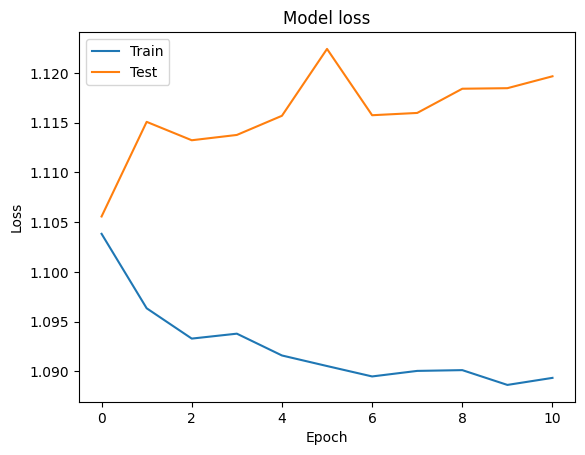

In [ ]:
# Plot training & validation loss values
plt.plot(history_model_4.history['loss'])
plt.plot(history_model_4.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


<Figure size 1000x700 with 0 Axes>

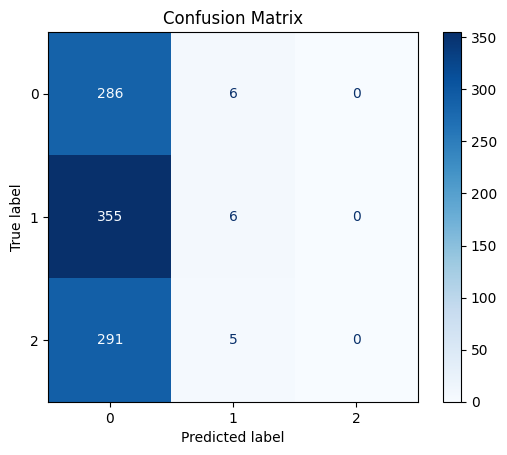

In [ ]:
# Assuming `grid_result` is the result from GridSearchCV and contains the best model

# Predict on the test set
y_pred = best_model_4.predict(X_test)

# Convert the one-hot encoded actual labels back to integer format
actual_categories = np.argmax(y_test, axis=1)

# Get the predicted categories
predicted_categories = np.argmax(y_pred, axis=1)

# Compute the confusion matrix
cm = confusion_matrix(actual_categories, predicted_categories)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1, 2])

# Plot the confusion matrix
plt.figure(figsize=(10, 7))
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import accuracy_score

# Assuming the functions to create and compile your model are defined as `create_model`

def compute_hit_rate(signals, percent_changes):
    correct_signals = 0
    total_signals = len(signals)

    for signal, percent_change in zip(signals, percent_changes):
        if (signal == 0 and percent_change < 0) or (signal == 2 and percent_change > 0):
            correct_signals += 1
        elif signal == 1:
            total_signals -= 1

    return correct_signals / total_signals if total_signals > 0 else 0

def backtest(actions, percent_changes):
    cash = 100  # Initial cash
    position = 0  # Current position: 0 for flat, -1 for short, 1 for long
    portfolio_value = []  # Portfolio value over time

    for action, percent_change in zip(actions, percent_changes):
        if action == 0:  # Sell
            position = -100  # Set position to short
            cash += position * percent_change  # Sell shares
        elif action == 1:  # Flat
            position = 0  # Set position to flat
            cash += 0  # No action
        elif action == 2:  # Buy
            position = 100  # Set position to long
            cash += position * percent_change  # Buy shares

        portfolio_value.append(cash)  # Calculate portfolio value

    return portfolio_value

def run_single_iteration(X_train, y_train, X_test, y_test, best_params_model_4):
    # Create the model with the best parameters
    best_model_4 = create_model_4(units1 = best_params_model_4['model__units1'],
                          dropout_rate1 = best_params_model_4['model__dropout_rate1'],
                          batch_size = best_params_model_4['batch_size']
                          )

    early_stopping_manual = EarlyStopping(monitor='val_loss', patience = 10, restore_best_weights = True)

    history_model_4 = best_model_4.fit(X_train, y_train,
                         epochs=100,
                         validation_data=(X_test, y_test),
                                   batch_size = 32, # remember to change (default 32).
                        callbacks = [early_stopping_manual],
                         verbose=0)

    # Predict on the test set
    predictions = best_model_4.predict(X_test)
    predicted_categories = np.argmax(predictions, axis=1)

    # Convert y_test from one-hot encoding to label format
    y_test_labels = np.argmax(y_test, axis=1)

    # Calculate accuracy
    accuracy = accuracy_score(y_test_labels, predicted_categories)

    # Generate signals based on predicted categories
    signals = predicted_categories
    percent_changes = np.array(df_raw_exchange.iloc[-len(y_test):])

    # Run the backtest
    portfolio_value = backtest(signals, percent_changes)
    hit_rate = compute_hit_rate(signals, percent_changes)
    num_trades = np.sum((signals == 0) | (signals == 2))


    return portfolio_value, accuracy, hit_rate, num_trades

# Number of iterations for averaging
iterations = 50

# Lists to store the results of each iteration
final_portfolio_values = []
accuracies = []
hit_rates = []
trade_counts = []

for i in range(iterations):
    print(f"Running iteration {i+1}/{iterations}")
    portfolio_value, accuracy, hit_rate, num_trades = run_single_iteration(X_train, y_train, X_test, y_test, best_params_model_4)
    final_portfolio_values.append(portfolio_value[-1])
    accuracies.append(accuracy)
    hit_rates.append(hit_rate)
    trade_counts.append(num_trades)
    print(f"Iteration {i+1} - Final Portfolio Value: {portfolio_value[-1]}, Accuracy: {accuracy}, Hit Rate: {hit_rate}, Trades: {num_trades}")

# Calculate the average and standard deviation of the final portfolio values
average_final_value = np.mean(final_portfolio_values)
std_final_value = np.std(final_portfolio_values)

# Calculate the average accuracy and hit rate
average_accuracy = np.mean(accuracies)
average_hit_rate = np.mean(hit_rates)
average_num_trades = np.mean(trade_counts)

# Print results
print("Average Final Portfolio Value:")
print(average_final_value)
print('Standard Deviation of Final Values:')
print(std_final_value)
print('Average Accuracy:')
print(average_accuracy)
print('Average Hit Rate:')
print(average_hit_rate)
print('Average No. of Trades:')
print(average_num_trades)

Running iteration 1/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
Iteration 1 - Final Portfolio Value: 96.34521046177825, Accuracy: 0.3076923076923077, Hit Rate: 0.5026343519494204, Trades: 949
Running iteration 2/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
Iteration 2 - Final Portfolio Value: 93.81178843289874, Accuracy: 0.3087460484720759, Hit Rate: 0.500542888165038, Trades: 921
Running iteration 3/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
Iteration 3 - Final Portfolio Value: 113.68251708537395, Accuracy: 0.33719704952581664, Hit Rate: 0.5061728395061729, Trades: 810
Running iteration 4/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
Iteration 4 - Final Portfolio Value: 95.88213986443522, Accuracy: 0.3055848261327713, Hit Rate: 0.5015806111696522, Trades: 949
Running iteration 5/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
Iteration 5 - Final Portfolio Value: 94.79579964625644, Accuracy: 0.30242360379346683, Hit Rate: 0.48788198103266595, Trades: 949
Running iteration 6/50
30/30 ━━━━━━━━━━━━━━━━━━

# 5th Iteration

Single layer LSTM with L2 regularization

In [38]:
from tensorflow.keras.regularizers import l2

In [39]:
time_steps = 15

dataX = create_dataset(dataset, time_steps)

dataX = np.reshape(dataX, (dataX.shape[0], time_steps, dataset.shape[1]))

X = dataX
y = y_categories[time_steps:]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

In [40]:
def create_model_5(units1=128, dropout_rate1 = 0.3, batch_size = 32, l2_value = 0.01):
    model = Sequential([
        Input(shape=(X_train.shape[1], X_train.shape[2])),
        LSTM(units1, return_sequences = False),
        Dropout(dropout_rate1),
        Dense(3, activation='softmax', kernel_regularizer = l2(l2_value))
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [41]:
model_5 = KerasClassifier(model = create_model_5, epochs = 75, verbose = 0, shuffle = False, random_state = 42)

In [42]:
param_grid_model5 = {
    'model__units1': [32, 64, 128],
    'model__dropout_rate1': [0.4, 0.3, 0.2],
    'batch_size': [32, 64, 128],
    'model__l2_value': [0.1, 0.05, 0.02]
}

In [43]:
# Perform Grid Search with 5-fold cross-validation
logging.info('Starting grid search...')
grid_model_5 = GridSearchCV(estimator = model_5, param_grid = param_grid_model5, cv = 5, n_jobs = -1)

In [ ]:
from keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor = 'val_loss', patience = 5, start_from_epoch = 10, restore_best_weights = True)

# Fit the grid search
grid_result_model_5 = grid_model_5.fit(X_train, y_train, validation_split = 0.2, callbacks = [early_stopping])

/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()


In [25]:
best_params_model_5 = grid_result_model_5.best_params_
logging.info(f"Best Parameters: {best_params_model_5}")
print(best_params_model_5)

{'batch_size': 64, 'model__dropout_rate1': 0.3, 'model__l2_value': 0.01, 'model__units1': 64}


In [26]:
best_model_5 = create_model_5(units1 = best_params_model_5['model__units1'],
                          dropout_rate1 = best_params_model_5['model__dropout_rate1'],
                          batch_size = best_params_model_5['batch_size'],
                          l2_value = best_params_model_5['model__l2_value'],
                          )

In [27]:
early_stopping_manual = EarlyStopping(monitor='val_loss', patience = 10, restore_best_weights = True)

history_model_5 = best_model_5.fit(X_train, y_train,
                         epochs = 75,
                         validation_data=(X_test, y_test),
                                   batch_size = 64, # remember to change if needed (default = 32)
                        callbacks = [early_stopping_manual],
                         verbose=0)

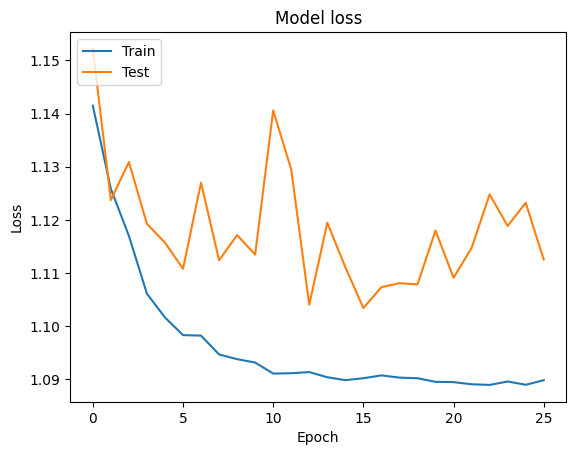

In [28]:
# Plot training & validation loss values
plt.plot(history_model_5.history['loss'])
plt.plot(history_model_5.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


<Figure size 1000x700 with 0 Axes>

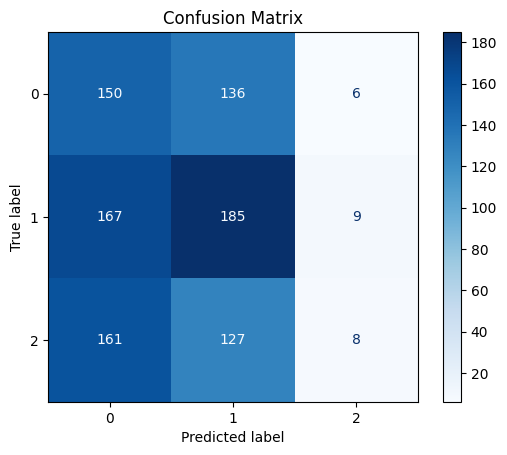

In [29]:
# Assuming `grid_result` is the result from GridSearchCV and contains the best model

# Predict on the test set
y_pred = best_model_5.predict(X_test)

# Convert the one-hot encoded actual labels back to integer format
actual_categories = np.argmax(y_test, axis=1)

# Get the predicted categories
predicted_categories = np.argmax(y_pred, axis=1)

# Compute the confusion matrix
cm = confusion_matrix(actual_categories, predicted_categories)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1, 2])

# Plot the confusion matrix
plt.figure(figsize=(10, 7))
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

In [33]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import accuracy_score

# Assuming the functions to create and compile your model are defined as `create_model`

def compute_hit_rate(signals, percent_changes):
    correct_signals = 0
    total_signals = len(signals)

    for signal, percent_change in zip(signals, percent_changes):
        if (signal == 0 and percent_change < 0) or (signal == 2 and percent_change > 0):
            correct_signals += 1
        elif signal == 1:
            total_signals -= 1

    return correct_signals / total_signals if total_signals > 0 else 0

def backtest(actions, percent_changes):
    cash = 100  # Initial cash
    position = 0  # Current position: 0 for flat, -1 for short, 1 for long
    portfolio_value = []  # Portfolio value over time

    for action, percent_change in zip(actions, percent_changes):
        if action == 0:  # Sell
            position = -100  # Set position to short
            cash += position * percent_change  # Sell shares
        elif action == 1:  # Flat
            position = 0  # Set position to flat
            cash += 0  # No action
        elif action == 2:  # Buy
            position = 100  # Set position to long
            cash += position * percent_change  # Buy shares

        portfolio_value.append(cash)  # Calculate portfolio value

    return portfolio_value

def run_single_iteration(X_train, y_train, X_test, y_test, best_params_model_5):
    # Create the model with the best parameters
    best_model_5 = create_model_5(units1 = best_params_model_5['model__units1'],
                          dropout_rate1 = best_params_model_5['model__dropout_rate1'],
                          batch_size = best_params_model_5['batch_size'],
                          l2_value = best_params_model_5['model__l2_value'],
                          )

    early_stopping_manual = EarlyStopping(monitor='val_loss', patience = 10, restore_best_weights = True)

    history_model_5 = best_model_5.fit(X_train, y_train,
                         epochs = 75,
                         validation_data=(X_test, y_test),
                                   batch_size = 128, # remember to change if needed (default = 32)
                        callbacks = [early_stopping_manual],
                         verbose=0)

    # Predict on the test set
    predictions = best_model_5.predict(X_test)
    predicted_categories = np.argmax(predictions, axis=1)

    # Convert y_test from one-hot encoding to label format
    y_test_labels = np.argmax(y_test, axis=1)

    # Calculate accuracy
    accuracy = accuracy_score(y_test_labels, predicted_categories)

    # Generate signals based on predicted categories
    signals = predicted_categories
    percent_changes = np.array(df_raw_exchange.iloc[-len(y_test):])

    # Run the backtest
    portfolio_value = backtest(signals, percent_changes)
    hit_rate = compute_hit_rate(signals, percent_changes)
    num_trades = np.sum((signals == 0) | (signals == 2))


    return portfolio_value, accuracy, hit_rate, num_trades

# Number of iterations for averaging
iterations = 50

# Lists to store the results of each iteration
final_portfolio_values = []
accuracies = []
hit_rates = []
trade_counts = []

for i in range(iterations):
    print(f"Running iteration {i+1}/{iterations}")
    portfolio_value, accuracy, hit_rate, num_trades = run_single_iteration(X_train, y_train, X_test, y_test, best_params_model_5)
    final_portfolio_values.append(portfolio_value[-1])
    accuracies.append(accuracy)
    hit_rates.append(hit_rate)
    trade_counts.append(num_trades)
    print(f"Iteration {i+1} - Final Portfolio Value: {portfolio_value[-1]}, Accuracy: {accuracy}, Hit Rate: {hit_rate}, Trades: {num_trades}")

# Calculate the average and standard deviation of the final portfolio values
average_final_value = np.mean(final_portfolio_values)
std_final_value = np.std(final_portfolio_values)

# Calculate the average accuracy and hit rate
average_accuracy = np.mean(accuracies)
average_hit_rate = np.mean(hit_rates)
average_num_trades = np.mean(trade_counts)

# Print results
print("Average Final Portfolio Value:")
print(average_final_value)
print('Standard Deviation of Final Values:')
print(std_final_value)
print('Average Accuracy:')
print(average_accuracy)
print('Average Hit Rate:')
print(average_hit_rate)
print('Average No. of Trades:')
print(average_num_trades)

Running iteration 1/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
Iteration 1 - Final Portfolio Value: 99.54412476390019, Accuracy: 0.35932560590094836, Hit Rate: 0.5063291139240507, Trades: 553
Running iteration 2/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step
Iteration 2 - Final Portfolio Value: 94.49430943989623, Accuracy: 0.3624868282402529, Hit Rate: 0.5, Trades: 426
Running iteration 3/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
Iteration 3 - Final Portfolio Value: 96.27923866109566, Accuracy: 0.3635405690200211, Hit Rate: 0.5009746588693957, Trades: 513
Running iteration 4/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
Iteration 4 - Final Portfolio Value: 104.39419278196789, Accuracy: 0.36037934668071653, Hit Rate: 0.5145985401459854, Trades: 548
Running iteration 5/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Iteration 5 - Final Portfolio Value: 101.64593049007861, Accuracy: 0.35511064278187565, Hit Rate: 0.5060422960725075, Trades: 662
Running iteration 6/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/st

# 6th Iteration


In [ ]:
time_steps = 15

dataX = create_dataset(dataset, time_steps)

dataX = np.reshape(dataX, (dataX.shape[0], time_steps, dataset.shape[1]))

X = dataX
y = y_categories[time_steps:]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False, random_state = 42)

In [ ]:
def create_model_6(units1 = 128, units2 = 64,  dropout_rate1 = 0.2, dropout_rate2 = 0.1, batch_size = 32, l2_value = 0.01):
    model = Sequential([
        Input(shape=(X_train.shape[1], X_train.shape[2])),
        LSTM(units1, return_sequences = True),
        Dropout(dropout_rate1),
        LSTM(units2, return_sequences = False),
        Dropout(dropout_rate2),
        Dense(3, activation = 'softmax', kernel_regularizer=l2(l2_value))
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [ ]:
param_grid_model_6 = {
    'model__units1': [64, 128],
    'model__units2': [64, 128],
    'model__dropout_rate1': [0.2, 0.3, 0.4],
    'model__dropout_rate2': [0.2, 0.3, 0.4],
    'batch_size': [64, 128],
    'model__l2_value': [0.1, 0.01]
}

In [ ]:
model_6 = KerasClassifier(model = create_model_6, epochs = 75, verbose = 0, shuffle = False, random_state = 42)

In [ ]:
# Perform Grid Search with 5-fold cross-validation
logging.info('Starting grid search...')
grid_model_6 = GridSearchCV(estimator=model_6, param_grid=param_grid_model_6, cv=5, scoring = 'accuracy', n_jobs = -1)

In [ ]:
from keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor = 'val_loss', patience = 5, start_from_epoch = 10, restore_best_weights = True)

# Fit the grid search
grid_result_model_6 = grid_model_6.fit(X_train, y_train, validation_split = 0.2, callbacks = [early_stopping])

/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()
/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


In [ ]:
best_params_model_6 = grid_result_model_6.best_params_
logging.info(f"Best Parameters: {best_params_model_6}")
print(best_params_model_6)

{'batch_size': 128, 'model__dropout_rate1': 0.4, 'model__dropout_rate2': 0.4, 'model__l2_value': 0.1, 'model__units1': 128, 'model__units2': 128}


In [ ]:
best_model_6 = create_model_6(units1 = best_params_model_6['model__units1'],
                              units2 = best_params_model_6['model__units2'],
                          dropout_rate1 = best_params_model_6['model__dropout_rate1'],
                              dropout_rate2 = best_params_model_6['model__dropout_rate2'],
                          batch_size = best_params_model_6['batch_size'],
                              l2_value = best_params_model_6['model__l2_value']
                          )

In [ ]:
early_stopping = EarlyStopping(monitor = 'val_loss', patience = 5, start_from_epoch = 10, restore_best_weights = True)

history_model_6 = best_model_6.fit(X_train, y_train,
                         epochs=75,
                                   batch_size = 128, # remember to change (default = 32)
                         validation_data=(X_test, y_test),
                                   callbacks = [early_stopping],
                         verbose=0)

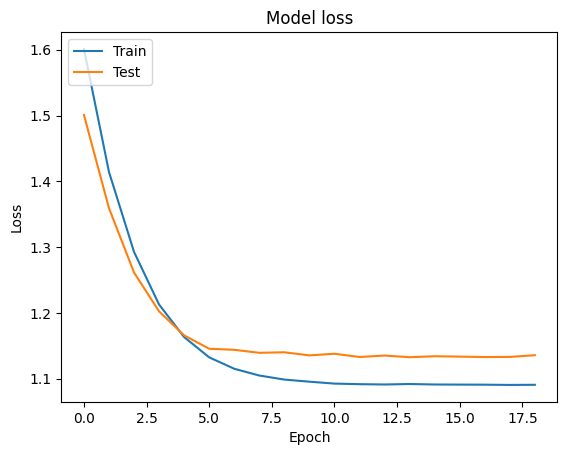

In [ ]:
# Plot training & validation loss values
plt.plot(history_model_6.history['loss'])
plt.plot(history_model_6.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


<Figure size 1000x700 with 0 Axes>

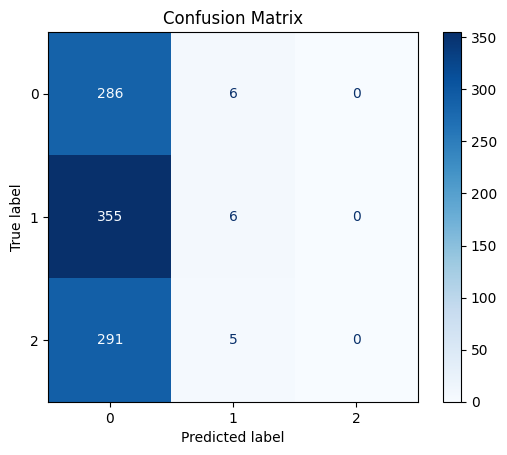

In [ ]:
# Assuming `grid_result` is the result from GridSearchCV and contains the best model

# Predict on the test set
y_pred = best_model_6.predict(X_test)

# Convert the one-hot encoded actual labels back to integer format
actual_categories = np.argmax(y_test, axis=1)

# Get the predicted categories
predicted_categories = np.argmax(y_pred, axis=1)

# Compute the confusion matrix
cm = confusion_matrix(actual_categories, predicted_categories)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1, 2])

# Plot the confusion matrix
plt.figure(figsize=(10, 7))
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import accuracy_score

# Assuming the functions to create and compile your model are defined as `create_model`

def compute_hit_rate(signals, percent_changes):
    correct_signals = 0
    total_signals = len(signals)

    for signal, percent_change in zip(signals, percent_changes):
        if (signal == 0 and percent_change < 0) or (signal == 2 and percent_change > 0):
            correct_signals += 1
        elif signal == 1:
            total_signals -= 1

    return correct_signals / total_signals if total_signals > 0 else 0

def backtest(actions, percent_changes):
    cash = 100  # Initial cash
    position = 0  # Current position: 0 for flat, -1 for short, 1 for long
    portfolio_value = []  # Portfolio value over time

    for action, percent_change in zip(actions, percent_changes):
        if action == 0:  # Sell
            position = -100  # Set position to short
            cash += position * percent_change  # Sell shares
        elif action == 1:  # Flat
            position = 0  # Set position to flat
            cash += 0  # No action
        elif action == 2:  # Buy
            position = 100  # Set position to long
            cash += position * percent_change  # Buy shares

        portfolio_value.append(cash)  # Calculate portfolio value

    return portfolio_value

def run_single_iteration(X_train, y_train, X_test, y_test, best_params_model_6):
    # Create the model with the best parameters
    best_model_6 = create_model_6(units1 = best_params_model_6['model__units1'],
                              units2 = best_params_model_6['model__units2'],
                          dropout_rate1 = best_params_model_6['model__dropout_rate1'],
                              dropout_rate2 = best_params_model_6['model__dropout_rate2'],
                          batch_size = best_params_model_6['batch_size'],
                              l2_value = best_params_model_6['model__l2_value']
                          )

    early_stopping = EarlyStopping(monitor = 'val_loss', patience = 5, start_from_epoch = 10, restore_best_weights = True)

    history_model_6 = best_model_6.fit(X_train, y_train,
                         epochs=75,
                                   batch_size = 128,
                         validation_data=(X_test, y_test),
                                   callbacks = [early_stopping],
                         verbose=0)

    # Predict on the test set
    predictions = best_model_6.predict(X_test)
    predicted_categories = np.argmax(predictions, axis=1)

    # Convert y_test from one-hot encoding to label format
    y_test_labels = np.argmax(y_test, axis=1)

    # Calculate accuracy
    accuracy = accuracy_score(y_test_labels, predicted_categories)

    # Generate signals based on predicted categories
    signals = predicted_categories
    percent_changes = np.array(df_raw_exchange.iloc[-len(y_test):])

    # Run the backtest
    portfolio_value = backtest(signals, percent_changes)
    hit_rate = compute_hit_rate(signals, percent_changes)
    num_trades = np.sum((signals == 0) | (signals == 2))


    return portfolio_value, accuracy, hit_rate, num_trades

# Number of iterations for averaging
iterations = 100

# Lists to store the results of each iteration
final_portfolio_values = []
accuracies = []
hit_rates = []
trade_counts = []

for i in range(iterations):
    print(f"Running iteration {i+1}/{iterations}")
    portfolio_value, accuracy, hit_rate, num_trades = run_single_iteration(X_train, y_train, X_test, y_test, best_params_model_6)
    final_portfolio_values.append(portfolio_value[-1])
    accuracies.append(accuracy)
    hit_rates.append(hit_rate)
    trade_counts.append(num_trades)
    print(f"Iteration {i+1} - Final Portfolio Value: {portfolio_value[-1]}, Accuracy: {accuracy}, Hit Rate: {hit_rate}, Trades: {num_trades}")

# Calculate the average and standard deviation of the final portfolio values
average_final_value = np.mean(final_portfolio_values)
std_final_value = np.std(final_portfolio_values)

# Calculate the average accuracy and hit rate
average_accuracy = np.mean(accuracies)
average_hit_rate = np.mean(hit_rates)
average_num_trades = np.mean(trade_counts)

# Print results
print("Average Final Portfolio Value:")
print(average_final_value)
print('Standard Deviation of Final Values:')
print(std_final_value)
print('Average Accuracy:')
print(average_accuracy)
print('Average Hit Rate:')
print(average_hit_rate)
print('Average No. of Trades:')
print(average_num_trades)

Running iteration 1/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Iteration 1 - Final Portfolio Value: 96.55242852422245, Accuracy: 0.2971548998946259, Hit Rate: 0.5005820721769499, Trades: 859
Running iteration 2/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
Iteration 2 - Final Portfolio Value: 88.65577949152967, Accuracy: 0.303477344573235, Hit Rate: 0.4944920440636475, Trades: 817
Running iteration 3/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Iteration 3 - Final Portfolio Value: 85.71726513449345, Accuracy: 0.3129610115911486, Hit Rate: 0.48673740053050396, Trades: 754
Running iteration 4/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Iteration 4 - Final Portfolio Value: 86.81982416582764, Accuracy: 0.2992623814541623, Hit Rate: 0.4841075794621027, Trades: 818
Running iteration 5/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Iteration 5 - Final Portfolio Value: 97.49341471902477, Accuracy: 0.303477344573235, Hit Rate: 0.5011764705882353, Trades: 850
Running iteration 6/100
30/30 ━━━━━━━━━━━━━━━━